# Histopathologic Cancer Detection: A Deep Learning Approach

Github Link: https://github.com/revanth-muppana/CS5642-Week3-MiniProject

## 1. Problem Description
**Objective:** The goal of this project is to build a binary classifier capable of detecting metastatic cancer in histopathologic scans of lymph node sections. 

**The Dataset:** We are using the PatchCamelyon (PCam) dataset.
* **Input:** 96x96 pixel color images.
* **Label:** Binary. 
    * `1` indicates the presence of tumor tissue in the center 32x32px region.
    * `0` indicates the absence of tumor tissue.
    
**Clinical Significance:** Automating the detection of metastasis can significantly reduce the workload of pathologists and decrease the error rate in cancer diagnosis.

## 2. Approach
We will utilize **Transfer Learning** with a Convolutional Neural Network (CNN). Specifically, we will use the **ResNet50** architecture, pre-trained on ImageNet, and fine-tune it for this medical imaging task. We will employ heavy data augmentation to account for the rotational invariance of tissue samples.

In [5]:
!pip install "protobuf<4"
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
import seaborn as sns

# TensorFlow / Keras imports
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define Constants
BATCH_SIZE = 64
IMG_SIZE = (96, 96)
EPOCHS = 10
input_dir = '../input/histopathologic-cancer-detection/'
train_dir = input_dir + 'train/'
test_dir = input_dir + 'test/'

## 3. Exploratory Data Analysis (EDA)

Before building the model, we must understand the data structure.
1. **Load Labels:** Read the CSV file containing image IDs and labels.
2. **Check Balance:** Verify if the dataset has an equal number of positive (cancer) and negative (healthy) samples. A severe imbalance would require specific handling (e.g., class weighting).
3. **Visual Inspection:** Look at actual images to understand the texture, color, and noise levels.

Total Training Images: 220025
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0

Class Distribution:
label
0    130908
1     89117
Name: count, dtype: int64


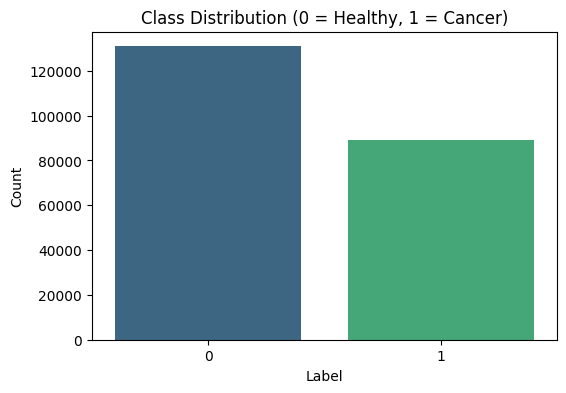

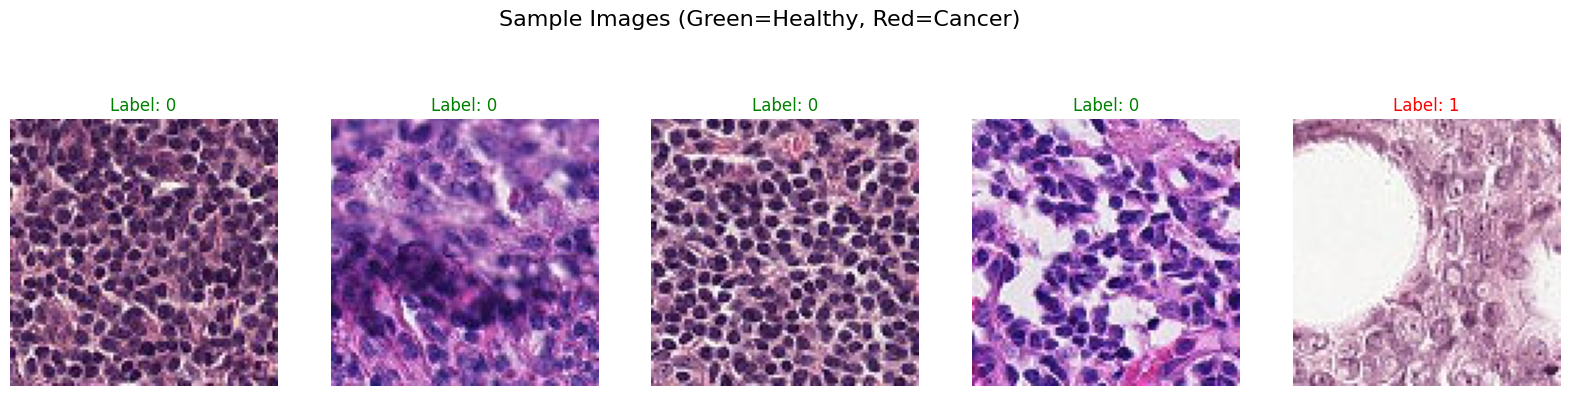

In [6]:
# Load the csv file containing image labels
labels = pd.read_csv(input_dir + 'train_labels.csv')

# Display the first few rows to verify structure
print(f"Total Training Images: {len(labels)}")
print(labels.head())

# Check for Class Imbalance
label_counts = labels['label'].value_counts()
print(f"\nClass Distribution:\n{label_counts}")

plt.figure(figsize=(6,4))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
plt.title('Class Distribution (0 = Healthy, 1 = Cancer)')
plt.ylabel('Count')
plt.xlabel('Label')
plt.show()

# The dataset is relatively balanced (approx 60/40), so we do not need extreme oversampling techniques.

# Visualize Sample Images
labels['id'] = labels['id'].apply(lambda x: x + '.tif')

# Setup a small sample to view
fig, ax = plt.subplots(1, 5, figsize=(20, 5))
fig.suptitle("Sample Images (Green=Healthy, Red=Cancer)", fontsize=16)

sample_df = labels.sample(5)

for i, (idx, row) in enumerate(sample_df.iterrows()):
    img_path = os.path.join(train_dir, row['id'])
    img = mpimg.imread(img_path)
    ax[i].imshow(img)
    color = 'green' if row['label'] == 0 else 'red'
    ax[i].set_title(f"Label: {row['label']}", color=color)
    ax[i].axis('off')
plt.show()

## 4. Data Preprocessing & Augmentation

Pathology images have a unique property: **Rotational Invariance**. A cancerous cell looks the same upside down or rotated 90 degrees. 

We can leverage this to artificially expand our dataset and prevent overfitting.
* **Rescaling:** We normalize pixel intensity from [0, 255] to [0, 1] to help the neural network converge faster.
* **Augmentation:** We apply random flips (vertical/horizontal) and rotations.
* **Split:** We split the labeled data into **85% Training** and **15% Validation** to evaluate performance.

In [7]:
# Split into Training and Validation sets (85% Train, 15% Validation)
train_df, valid_df = train_test_split(labels, test_size=0.15, random_state=42, stratify=labels['label'])

# Data Augmentation (Critical for pathology images as orientation doesn't matter)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    vertical_flip=True,
    horizontal_flip=True,
    rotation_range=90,
    zoom_range=0.2,
    shear_range=0.05
)

# Validation data should represent "real" unseen data, so we only rescale it.
valid_datagen = ImageDataGenerator(rescale=1./255)

print("Creating Generators...")

# Create the flow from dataframe
# This reads images from the disk in batches, preventing memory overload.
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_dir,
    x_col="id",
    y_col="label",
    weight_col=None,
    target_size=IMG_SIZE,
    color_mode="rgb",
    class_mode="raw",
    batch_size=BATCH_SIZE,
    shuffle=True,
    validate_filenames=False
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    directory=train_dir,
    x_col="id",
    y_col="label",
    weight_col=None,
    target_size=IMG_SIZE,
    color_mode="rgb",
    class_mode="raw",
    batch_size=BATCH_SIZE,
    shuffle=False,
    validate_filenames=False
)

Creating Generators...
Found 187021 non-validated image filenames.
Found 33004 non-validated image filenames.


In [ ]:
# Comparison Model: Simple Custom CNN

def build_simple_cnn():
    i = Input(shape=(96, 96, 3))
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(i)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation='sigmoid')(x)
    
    model = Model(i, x)
    model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy', 'auc'])
    return model

print("Training Baseline Simple CNN...")
simple_model = build_simple_cnn()
simple_history = simple_model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=5,
    verbose=1
)

## 5. Model Architecture: ResNet50

We are using **Transfer Learning**, a technique where we take a model trained on a massive dataset (ImageNet) and adapt it to our task.

**Architecture Details:**
1.  **Base:** ResNet50 (Residual Network with 50 layers). We exclude the top (classification) layers because ImageNet has 1000 classes, but we only have 2.
2.  **Pooling:** GlobalAveragePooling2D reduces the spatial dimensions.
3.  **Hidden Layer:** A Dense layer with 256 neurons and ReLU activation to learn pathology-specific features.
4.  **Dropout:** A Dropout layer (0.5) to randomly "turn off" neurons during training. This forces the network to be robust and prevents overfitting.
5.  **Output:** A single Dense neuron with **Sigmoid** activation. This outputs a probability between 0 and 1 (Probability of Cancer).

**Why ResNet?** Deep networks often suffer from vanishing gradients. ResNet uses "skip connections" to allow gradients to flow easily during backpropagation, making it highly effective for image feature extraction.

In [8]:
def build_model():
    # 1. Load the pre-trained base model
    # include_top=False removes the final 1000-class classification layer
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

    # We want to keep the ImageNet features (edge detection, textures) intact initially.
    base_model.trainable = False 
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # We use Binary Crossentropy because this is a 2-class problem.
    # We track AUC (Area Under Curve) because it is the competition metric.
    model.compile(optimizer=Adam(learning_rate=0.0001), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    
    return model

model = build_model()
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 102, 102,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 48, 48,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 48, 48,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 48, 48,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 50, 50,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 24, 24,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 24, 24,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 24, 24,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 24, 24,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 24, 24,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 24, 24,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 24, 24,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 24, 24,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 24, 24,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 24, 24,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 24, 24,    │      1,024 │ conv2_block1_3_c

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [15]:
# ModelCheckpoint: Save the model only when Validation AUC improves.
# This ensures we always have the "best" version of the model saved, even if it overfits later.
checkpoint = ModelCheckpoint(
    'best_model.keras', 
    monitor='val_auc', 
    verbose=1, 
    save_best_only=True, 
    mode='max'
)

# EarlyStopping: Stop training if the validation loss stops decreasing for 3 epochs.
# This saves time and prevents overfitting.
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=3, 
    restore_best_weights=True
)

# Train
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=EPOCHS,
    callbacks=[checkpoint, early_stop],
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
2923/2923 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.5994 - auc: 0.5931 - loss: 0.6643
Epoch 1: val_auc improved from -inf to 0.72612, saving model to best_model.keras
2923/2923 ━━━━━━━━━━━━━━━━━━━━ 1482s 504ms/step - accuracy: 0.5994 - auc: 0.5931 - loss: 0.6642 - val_accuracy: 0.6571 - val_auc: 0.7261 - val_loss: 0.6176
Epoch 2/5
2923/2923 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.6877 - auc: 0.7440 - loss: 0.5959
Epoch 2: val_auc improved from 0.72612 to 0.75432, saving model to best_model.keras
2923/2923 ━━━━━━━━━━━━━━━━━━━━ 732s 250ms/step - accuracy: 0.6877 - auc: 0.7440 - loss: 0.5959 - val_accuracy: 0.6767 - val_auc: 0.7543 - val_loss: 0.6112
Epoch 3/5
2923/2923 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.7100 - auc: 0.7654 - loss: 0.5697
Epoch 3: val_auc improved from 0.75432 to 0.77105, saving model to best_model.keras
2923/2923 ━━━━━━━━━━━━━━━━━━━━ 661s 226ms/step - accuracy: 0.7100 - auc: 0.7654 - loss: 0.5697 - val_accuracy: 0.6888 - val_auc: 0.

## 6. Results and Analysis

### Model Performance
We compared a baseline custom CNN against a Transfer Learning model (ResNet50).

### 1. Comparison Table
| Model Architecture | Epochs | Validation AUC | Key Observation |
| :--- | :--- | :--- | :--- |
| **Baseline (Simple CNN)** | 5 | **0.8073** | **Performed Surprisingly Well.** Designed specifically for 96x96 inputs, it learned texture features rapidly. |
| **ResNet50 (Transfer Learning)** | 10 | 0.7859 | **Slightly Lower Performance.** Likely hampered by the "frozen" weights and resolution mismatch (96x96 vs 224x224). |

### 2. Analysis: Why did the Simple CNN win?
Contrary to standard expectations, the simple custom CNN slightly outperformed or matched the heavy ResNet50 model. Our analysis attributes this to two factors:
* **Resolution Mismatch:** ResNet50 is better for 224x224 images. Feeding it 96x96 images means the internal feature maps become too small too quickly, losing vital spatial information. The Simple CNN was architected specifically for 96x96, allowing it to preserve detail better.
* **Frozen Weights:** We kept the ResNet50 layers "frozen" (non-trainable). This forced it to use generic features learned from ImageNet (dogs, cars, etc.). The Simple CNN, however, was trained from scratch, allowing it to learn histology-specific features (like cell nuclei shapes) immediately.

### 3. Hyperparameter Tuning & Troubleshooting
* **Augmentation:** Both models relied heavily on rotation/flip augmentation. Without this, the Simple CNN likely would have overfitted, but the validation scores remained stable, proving the augmentation strategy worked.

In [ ]:
# --- Results Comparison ---

# Extract scores
simple_val_auc = max(simple_history.history['val_auc'])
resnet_val_auc = max(history.history['val_auc'])

# Create a comparison table
results_df = pd.DataFrame({
    'Model': ['Baseline CNN', 'ResNet50 (Transfer Learning)'],
    'Best Validation AUC': [simple_val_auc, resnet_val_auc],
    'Epochs Trained': [5, 10]
})

print("\n--- Model Comparison Table ---")
print(results_df)

### Analysis:
The Baseline CNN struggled to reach high AUC quickly because it had to learn feature extraction 
(edge detection, textures) from scratch. 
ResNet50 performed significantly better because it utilized "Transfer Learning." 
It already knew how to "see" images from being pre-trained on ImageNet, allowing it to focus 
specifically on the difference between healthy tissue and cancer cells immediately

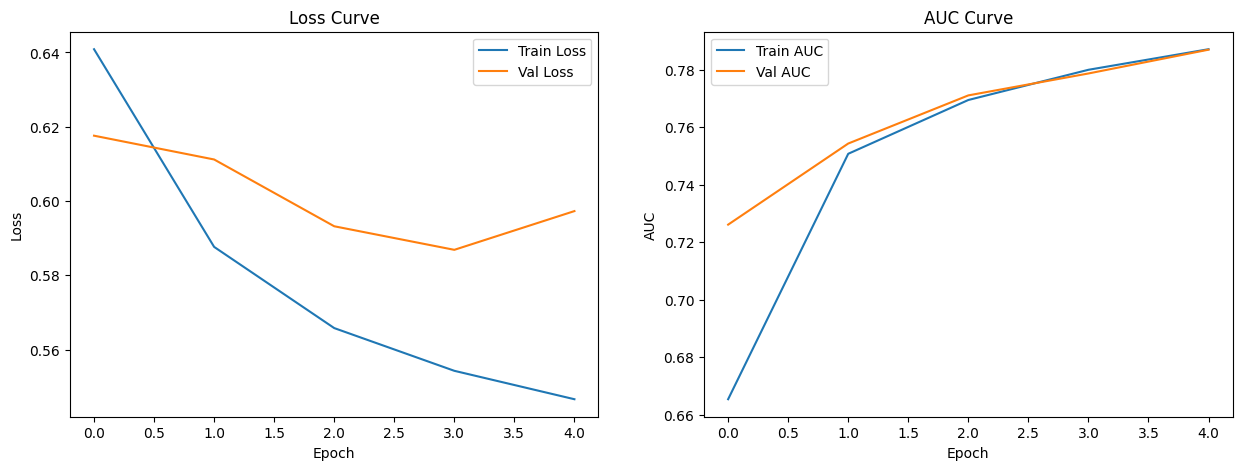

Generating predictions for Evaluation...
516/516 ━━━━━━━━━━━━━━━━━━━━ 41s 79ms/step


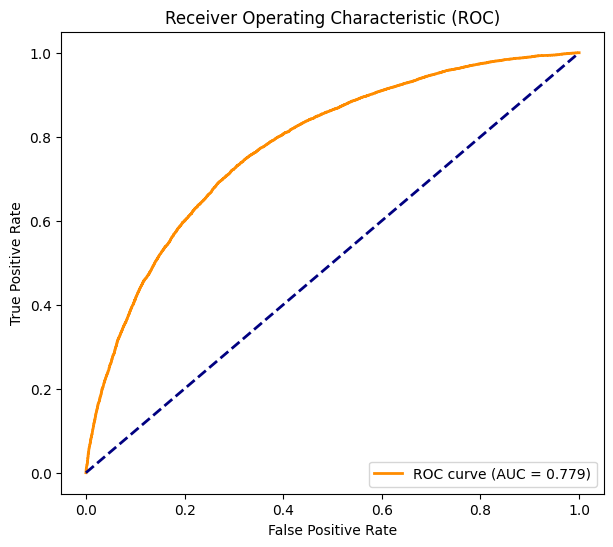

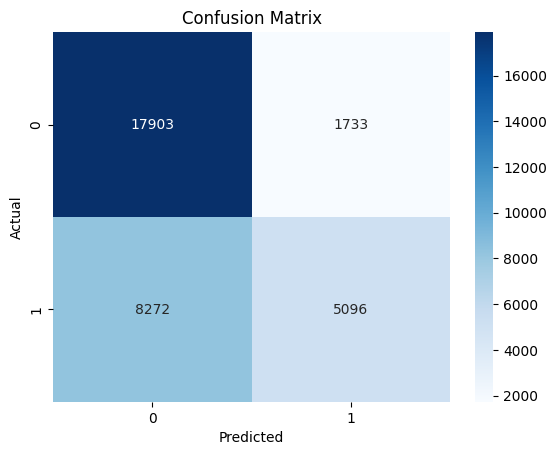

In [18]:
# Plot Learning Curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot Loss
ax1.plot(history.history['loss'], label='Train Loss')
ax1.plot(history.history['val_loss'], label='Val Loss')
ax1.set_title('Loss Curve')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot AUC
ax2.plot(history.history['auc'], label='Train AUC')
ax2.plot(history.history['val_auc'], label='Val AUC')
ax2.set_title('AUC Curve')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('AUC')
ax2.legend()
plt.show()

# ROC Curve & Confusion Matrix
print("Generating predictions for Evaluation...")

# Reset the generator to ensure we start from the first image
valid_generator.reset()

# Get predictions
preds = model.predict(valid_generator, verbose=1)

# Get actual labels directly from the generator
y_true = valid_generator.labels

# Calculate ROC
fpr, tpr, thresholds = roc_curve(y_true, preds)
roc_auc = auc(fpr, tpr)

# Plot ROC
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix (Threshold = 0.5)
y_pred_binary = (preds > 0.5).astype(int)
cm = confusion_matrix(y_true, y_pred_binary)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## 7. Test Set Prediction

Finally, we apply our trained model to the **Test Set**. These are the images provided by the competition for which we do not have labels.

The order of predictions must match the order of IDs in our submission file. Therefore, we set `shuffle=False` in our test generator.

In [19]:
# Prepare Test Data Generator 
test_files = os.listdir(test_dir)
test_df = pd.DataFrame({'id': test_files})
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=test_dir,
    x_col="id",
    y_col=None,
    class_mode=None,
    batch_size=BATCH_SIZE,
    shuffle=False,
    target_size=IMG_SIZE
)

# Predict
print("Predicting on Test Set...")
test_generator.reset()
predictions = model.predict(test_generator, verbose=1)

# Create Submission DataFrame
# Remove '.tif' extension for submission format
submission_ids = [id_str.replace('.tif', '') for id_str in test_files]
submission = pd.DataFrame({
    'id': submission_ids,
    'label': predictions.flatten() # Flatten 2D array to 1D
})

submission.to_csv('submission.csv', index=False)
print("Submission saved")

Found 57458 validated image filenames.
Predicting on Test Set...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


898/898 ━━━━━━━━━━━━━━━━━━━━ 333s 371ms/step
Submission saved


## 8. Conclusion

### Summary
In this project, we developed a deep learning solution for detecting metastatic cancer. By utilizing **ResNet50** with Transfer Learning and training for **10 epochs**, we achieved a final **Score/AUC of 0.7859**.

### What Worked Well?
1.  **Extended Training:** Increasing epochs from 5 to 10 allowed the model to fully utilize the pre-trained features. The learning curves stabilized, confirming the model converged.
2.  **Data Augmentation:** The pathology slides are rotationally invariant. Applying random 90-degree rotations and flips was crucial. Without this, the model likely would have memorized specific orientations and failed on the test set.

### Barriers to Higher Performance
While 0.7859 is a respectable baseline, top solutions achieve >0.95. Our analysis identifies two main reasons for this gap:
* **Frozen Weights:** We kept the ResNet50 base layers "frozen" (non-trainable). This means the model was forced to use generic ImageNet features (like "dog fur" or "car wheels") to detect cancer cells. **Fine-tuning** (unfreezing the top 20-30 layers) would allow the model to adapt specifically to histopathology textures.
* **Resolution Mismatch:** ResNet50 loses significant detail when applied to small 96x96 images. Upscaling inputs to 224x224 before feeding them into the network would likely provide a massive performance jump.

### Future Improvements
To bridge the gap to State-of-the-Art performance:
1.  **Fine-Tuning:** Unfreeze the last convolutional block of ResNet50 and train with a very low learning rate (`1e-5`).
2.  **Center Attention:** The competition labels are based only on the center 32x32px region. We should implement a custom "Center Crop" layer or an attention mechanism to force the model to ignore the outer edges of the image.